# Block 11: Multi Layer Perceptron

In [5]:
import sklearn.metrics
import numpy as np
import jax
import jax.numpy as jnp
from typing import List
import pandas as pd
import numpy.random as rng
import matplotlib.pyplot as plt

## The Kinds of Functions that an MLP Can Represent

(10000, 10)
(10000,)


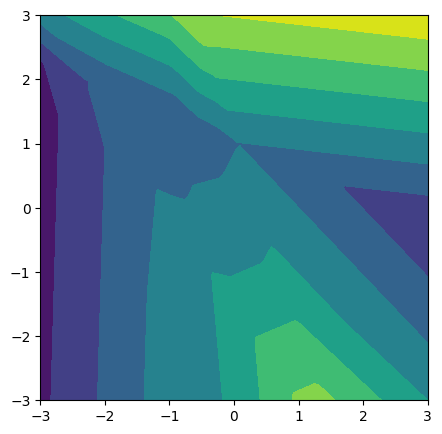

In [6]:
# Create a grid of points
K = 100
xs = jnp.linspace(-3, 3, K)
x1s, x2s = jnp.meshgrid(xs, xs)

# Number of data points x 2
X = jnp.vstack((x1s.flatten(), x2s.flatten())).T

# try varying the number of hidden units and see what happens
n_hidden = 10

# try changing seed to get different functions
rng = jax.random.key(856785768)

# weight matrix from inputs to hidden neurons
W_input_hidden = jax.random.normal(rng, (2, n_hidden)) # 2xH
rng, _ = jax.random.split(rng) # move to next seed

# bias of the hidden neurons
b_hidden = jax.random.normal(rng, n_hidden) # H
rng, _ = jax.random.split(rng) # move to next seed

# weight matrix from hidden neurons to output
W_hidden_output = jax.random.normal(rng, n_hidden) # H
rng, _ = jax.random.split(rng) # move to next seed

# bias of the output neuron
b_output = jax.random.normal(rng) # 1

# compute hidden activation
# We are using a RELU unit here
# Try removing the non-linearity and see what happens
u = jnp.maximum(0, b_hidden + X @ W_input_hidden ) # H + Nx2 @ 2xH = NxH
print(u.shape)

# compute output
y = b_output + u @ W_hidden_output # 1 + NxH @ Hx1 = Nx1
print(y.shape)

# plot
Z = jnp.reshape(y, (K, K))
f, ax = plt.subplots(1, 1, figsize=(5, 5))
cp = ax.contourf(x1s, x2s, Z)

# Implementing an MLP

In [8]:
def prepare_inputs(input_df):
    """
        Prepares the input features that will be fed into the model.

        Inputs:
            input_df: the input dataframe into the function. Should consist ONLY of input features.
        Outputs:
            Z: the input feature matrix of size NxK, where K is the number of features
    """
    # Let's identify categorical columns in a dataframe
    categorical_cols = input_df.select_dtypes(include='object').columns
    
    # Let's identify the numeric columns in the dataframe
    numeric_cols = input_df.select_dtypes(include='number').columns

    # We want to construct the input features into the model
    # We will use a numpy array that contains both numeric and categorically encoded values
    X = input_df[numeric_cols].to_numpy() # (NxK)
    
    # Now we need to z-score the numeric features so that they can lead to efficient learning
    col_means = np.mean(X, axis=0) # K
    col_stds = np.std(X, axis=0, ddof=1) # K
    
    # Z-score
    # (NxK - 
    #  1xK) 
    #  / 
    #  (1xK)
    Z = (X - col_means[None, :]) / col_stds[None, :]
    
    # Now we want to code the categorical columns using one-hot encoding
    for col in categorical_cols:
        # NxC (C is the number of unique values in the column)
        # So for origin this will be Nx3 
        dummies = pd.get_dummies( input_df[col] ).to_numpy() 
        
        # concatenate dummies matrix onto Z
        #print(Z.shape)
        #print(dummies.shape)
        Z = np.hstack((Z, dummies)) 
    
    # finally we want to add a column of ones at the start of Z
    ones_col = np.ones((Z.shape[0], 1)) # Nx1
    
    Z = np.hstack((ones_col, Z))

    return Z

def forward_fn(params, Z):
    """
        MLP forward function: implements an MLP with one hidden layer of relu units.
       
        Inputs:
            params: the coefficients of the model (size K)
            Z: the input feature matrix, as returned by prepare_inputs (size NxK)
        Output:
            yhat: the model's predictions (size N)
    """
    # NxM @ MxH = NxH
    h = jnp.maximum(0, Z @ params['W_ih']) # RELU activation
    f = h @ params['W_ho'] + params['b_o'] # NxH @ H = N
    p = 1/(1+jnp.exp(-f))
    return p 

def predict(params, input_df):
    """
        Convienience function that prepares inputs and runs the forward function.

        Inputs:
            params: the weights of the model (size K)
            input_df: input data frame (input features only, no output column).
        Output:
            yhat: the model's predictions (size N)
    """
    Z = prepare_inputs(input_df)
    return forward_fn(params, Z)

def loss_fn(params, Z, y):
    """
        Computes the negative cross-entropy loss function for the model.

        Inputs:
            params: the weights of the model (size K)
            Z: the input feature matrix, as returned by prepare_inputs (size NxK)
            y: actual observations (size N)
        Output:
            loss: negative binary cross entropy
    """
    yhat = forward_fn(params, Z)
    loss = -jnp.mean(y * jnp.log(yhat) + (1-y) * jnp.log(1-yhat))
    return loss 

def optimize(rng, input_df, y, learning_rate, epochs, n_hidden):
    """
        Input parameters:
            rng: JAX random key
            input_df: dataframe containing input columns
            y: a vector of outputs that we wish to predict
            learning_rate: how quickly we want gradient descent learning
            epochs: the number of steps of gradient descent
            n_hidden: number of hidden units
        Output:
            Beta: fitted model parameters
    """
    
    # move y into jax's domain
    y = jnp.array(y) # <-- JAX

    # Create a function that computes the gradient of the loss_fn with respect to the first argument (Beta)
    grad_fn = jax.grad(loss_fn) # <-- JAX

    # Prepare our inputs 
    Z = prepare_inputs(input_df) # NxK
    
    # Randomly initialize our solution 
    rng2, rng3, rng4 = jax.random.split(rng, 3)
    params = dict(
        # Weights from input to hidden layer
        W_ih = jax.random.normal(rng, (Z.shape[1], n_hidden)) * jnp.sqrt(1/Z.shape[1]), 

        # Weights from hidden to output neuron
        W_ho = jax.random.normal(rng2, n_hidden) * jnp.sqrt(1/n_hidden),

        # Bias of the output neuron
        b_o = jax.random.normal(rng3)
    )

    # Run gradient descent loop
    for i in range(epochs):

        # compute gradient
        W_grad = grad_fn(params, Z, y)
                
        # update solution
        params['W_ih'] = params['W_ih'] - learning_rate * W_grad['W_ih']
        params['W_ho'] = params['W_ho'] - learning_rate * W_grad['W_ho']
        params['b_o'] = params['b_o'] - learning_rate * W_grad['b_o']

    return params

# We will create little function that takes the training dataframe and the testing dataframe
def mlp_train_test_function(rng, train_df, test_df, input_cols, output_col, n_hidden):

    # build the training input data frame
    train_input_df = train_df[input_cols]

    # build the training outputs
    y = train_df[output_col].to_numpy()
    
    # Optimize the model using gradient descent
    best_params = optimize(rng,
                           input_df = train_input_df,
                           y = y,
                           learning_rate = 0.1,
                           epochs = 100,
                           n_hidden=n_hidden)

    # build the testing input data frame
    test_input_df = test_df[input_cols]

    # Make predictions on the test set
    yhat = predict(params = best_params,
                   input_df = test_input_df)
    
    # Calculate error of those predictions
    ytest = test_df[output_col].to_numpy()
    
    # we'll use accuracy for now
    return sklearn.metrics.accuracy_score(ytest, yhat > 0.5)

df = pd.read_csv("../data/nonseparable_binary_data.csv")
df

rng = jax.random.key(42)

accuracy = mlp_train_test_function(rng,
                                  train_df=df,
                                  test_df=df,
                                  input_cols=['x1','x2'],
                                  output_col='y',
                                  n_hidden=2)
accuracy

0.574

# Visualizing Output

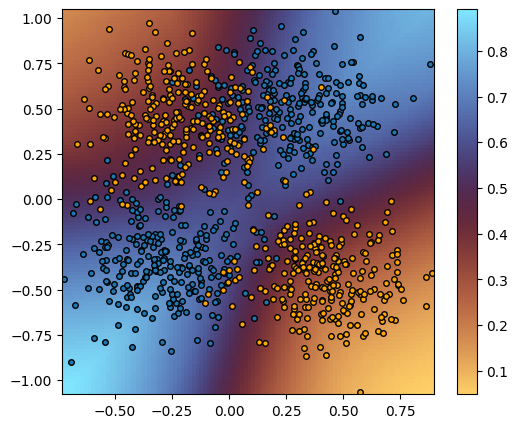

In [9]:
# Optimize the model using gradient descent
best_params = optimize(rng,
                      input_df = df[['x1','x2']],
                      y = df.y.to_numpy(),
                      learning_rate = 0.1,
                      epochs = 100,
                      n_hidden=20)

# initialize range of input values

min_x = np.min(df[['x1', 'x2']].to_numpy(), axis=0)
max_x = np.max(df[['x1', 'x2']].to_numpy(), axis=0)

K = 100
x1s = np.linspace(min_x[0], max_x[0], K)
x2s = np.linspace(min_x[1], max_x[1], K)
x1s, x2s = np.meshgrid(x1s, x2s)

# zip the inputs up into a (K*K, 2) array
Xstar = np.vstack((x1s.flatten(), x2s.flatten())).T

df_star = pd.DataFrame(data=Xstar, columns=['x1','x2'])

yhat = predict(params = best_params, input_df = df_star).reshape((K,K))

f, ax = plt.subplots(1, 1, figsize=(6, 5))

cp = ax.pcolor(x1s, x2s, yhat, cmap=plt.get_cmap('managua')) # 0: orange, 1: blue
f.colorbar(cp)

#
# plot the actual points
#
X = df[['x1','x2']].to_numpy()

y = df['y'].to_numpy()
class0_ix = y == 1 # y = 1, blue
class1_ix = y == 0 # y = 0, orange

ax.plot(X[class0_ix, 0], X[class0_ix, 1], marker='o', markersize=4, linestyle='', markeredgecolor='black', markeredgewidth=1)
ax.plot(X[class1_ix, 0], X[class1_ix, 1], color='orange', marker='o', markersize=4, linestyle='', markeredgecolor='black', markeredgewidth=1)
